[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


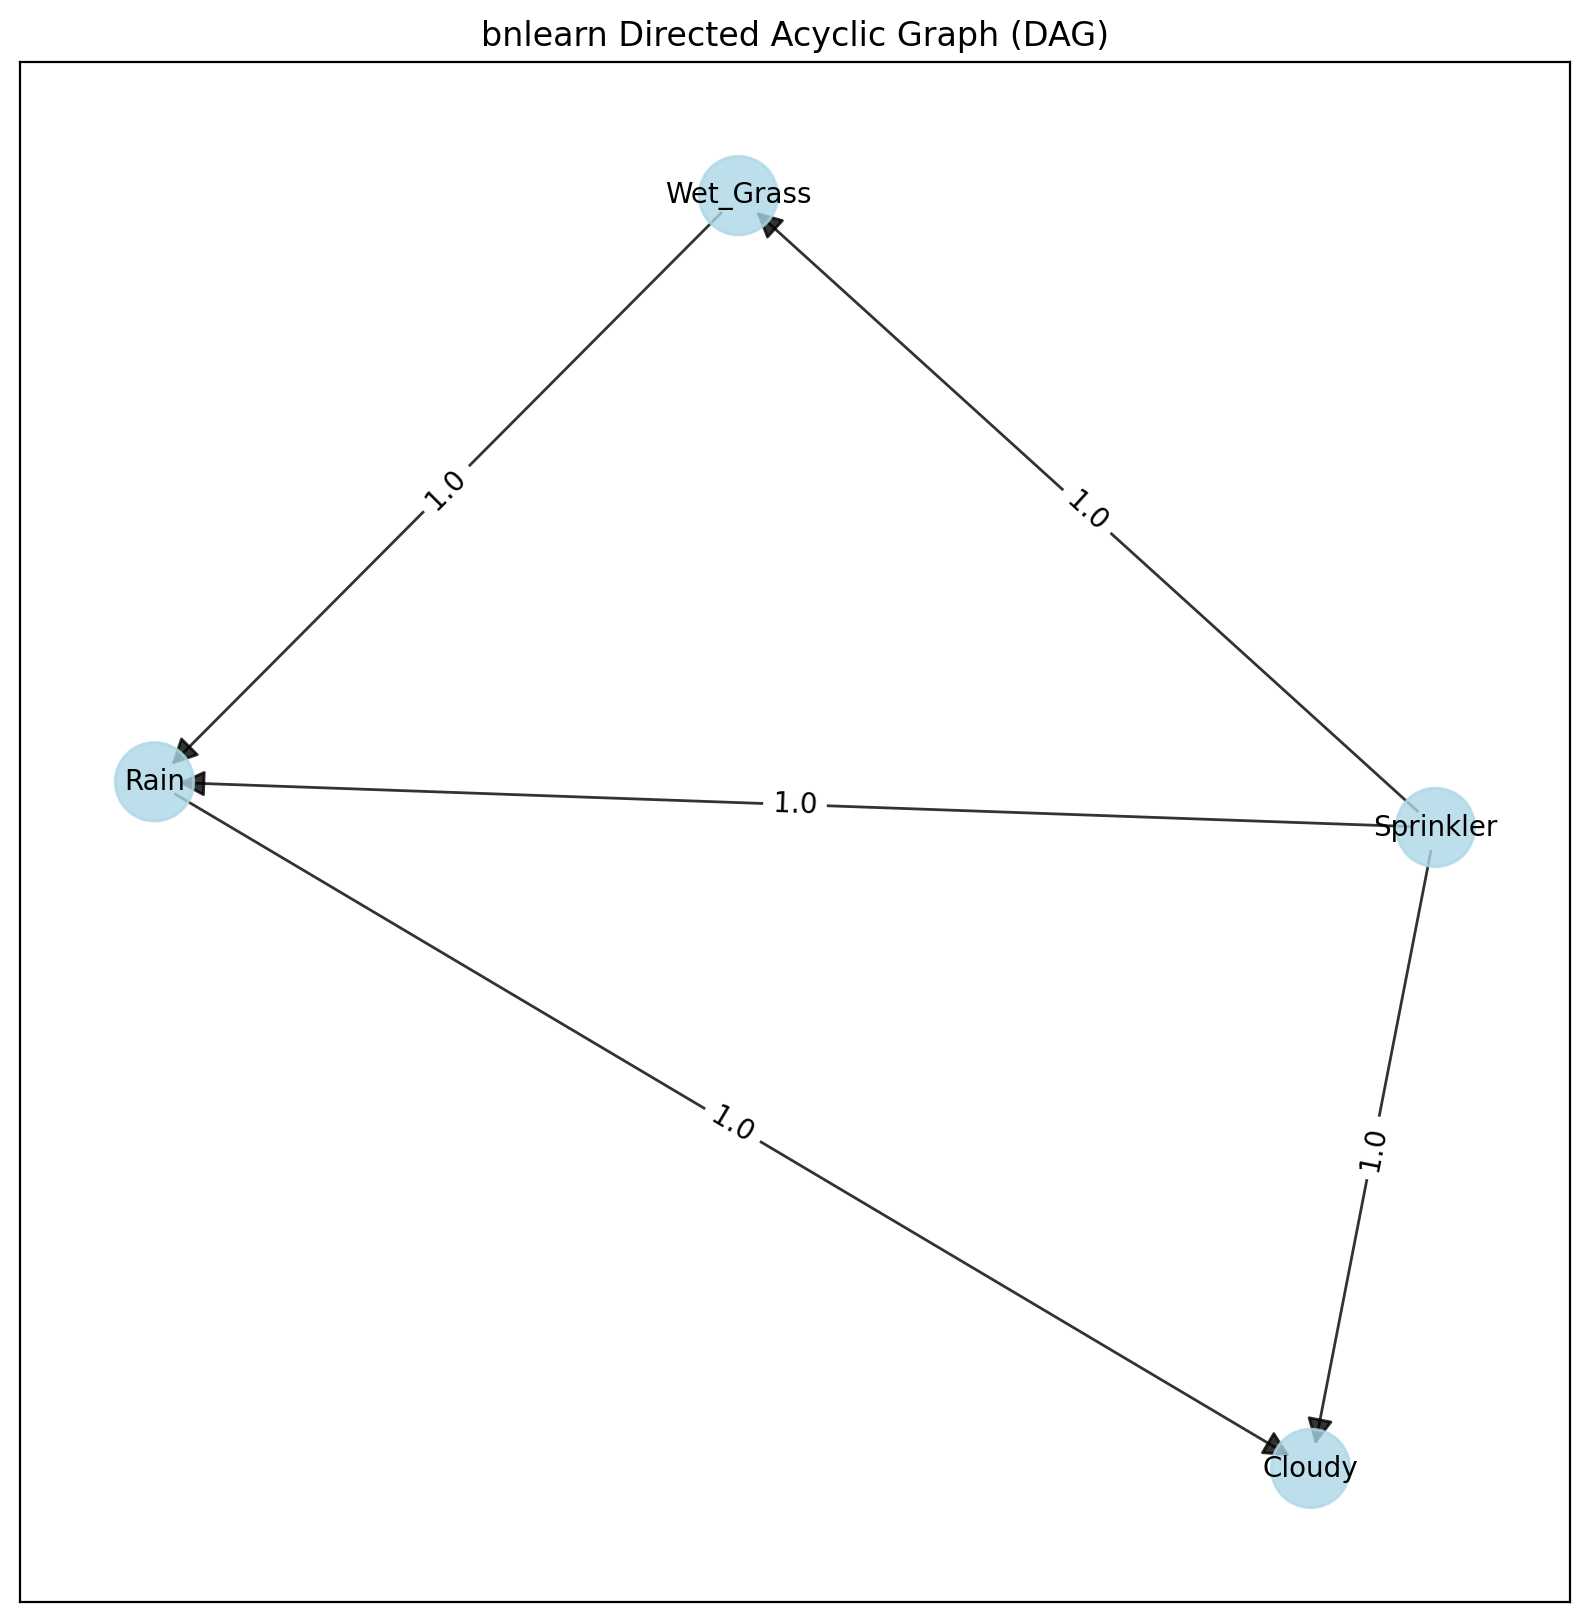

In [1]:
# Test bnlearn
import bnlearn as bn
df = bn.import_example()
model = bn.structure_learning.fit(df)
G = bn.plot(model)

In [3]:
# Test pgmpy
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

# 1. Define a simple network structure
# A -> B -> C
model = BayesianNetwork([('A', 'B'), ('B', 'C')])

# 2. Define CPDs (Conditional Probability Distributions)
cpd_a = TabularCPD(variable='A', variable_card=2, values=[[0.6], [0.4]])
cpd_b = TabularCPD(variable='B', variable_card=2,
                   values=[[0.7, 0.2],   # P(B=0|A)
                           [0.3, 0.8]],  # P(B=1|A)
                   evidence=['A'],
                   evidence_card=[2])
cpd_c = TabularCPD(variable='C', variable_card=2,
                   values=[[0.9, 0.1],
                           [0.1, 0.9]],
                   evidence=['B'],
                   evidence_card=[2])

# 3. Add CPDs to the model
model.add_cpds(cpd_a, cpd_b, cpd_c)

# 4. Check if model is valid
assert model.check_model(), "Model is invalid!"

# 5. Perform inference
infer = VariableElimination(model)
result = infer.query(variables=['C'], evidence={'A': 1})
print("P(C | A=1):")
print(result)


P(C | A=1):
+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.2600 |
+------+----------+
| C(1) |   0.7400 |
+------+----------+


Using device: cpu
Iter 1/50 - Loss: 0.942
Iter 11/50 - Loss: 0.516
Iter 21/50 - Loss: 0.200
Iter 31/50 - Loss: 0.028
Iter 41/50 - Loss: 0.048


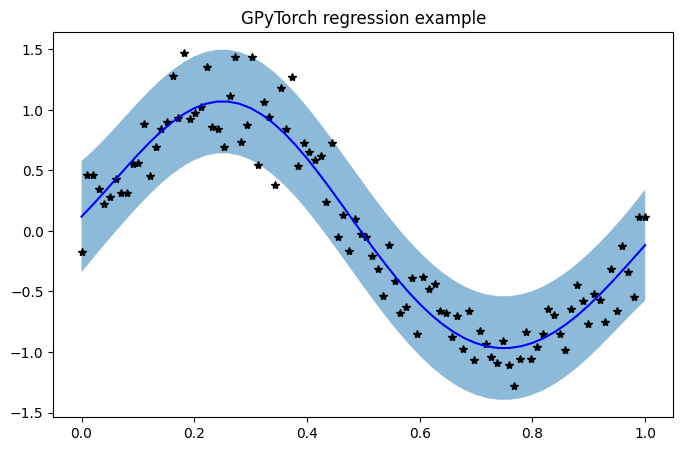

In [6]:
# Test GPyTorch
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Training data: simple noisy sine function
train_x = torch.linspace(0, 1, 100, device=device)
train_y = torch.sin(train_x * (2 * math.pi)) + 0.2 * torch.randn(train_x.size(), device=device)

# Define a simple GP Model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(train_x, train_y, likelihood).to(device)

# Find optimal model hyperparameters
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    if i % 10 == 0:
        print(f'Iter {i + 1}/{training_iter} - Loss: {loss.item():.3f}')
    optimizer.step()

# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
test_x = torch.linspace(0, 1, 51, device=device)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

# Plot results
f, ax = plt.subplots(figsize=(8, 5))
# Plot training data as black stars
ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*')
# Plot predictive mean as blue line
ax.plot(test_x.cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
# Shade confidence
lower, upper = observed_pred.confidence_region()
ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.set_title("GPyTorch regression example")
plt.show()
